In [38]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
signal_trees = ObjIter([Tree(fn) for fn in fc.eightb.preselection.signal_list])

In [40]:
bkg_trees = ObjIter([Tree(fc.eightb.preselection.Bkg_MC_List)])

In [41]:
signal_trees = signal_trees.apply(EventFilter('eightb_presel',nfound_presel=8).filter)

In [42]:
bkg_trees = bkg_trees.apply(EventFilter('passthrough',n_jet_emin=0).filter)

In [43]:
for signal in signal_trees: signal.color = None

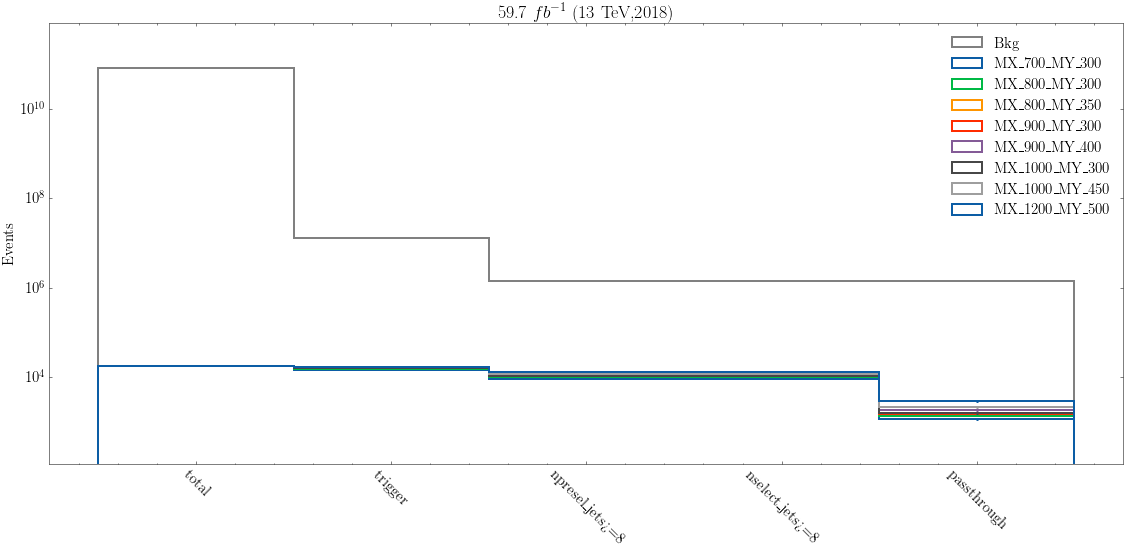

(<Figure size 1152x576 with 1 Axes>,
 <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, ylabel='Events'>)

In [44]:
study.cutflow(bkg_trees + signal_trees)

In [45]:
signal_trees.extend(kwargs=lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_bjet',ptordered=True))

In [46]:
ptbins = (20,40,60,80)

def gen_bjet_ptmulti(tree):
    tree.extend(
        **{
            f"n_gen_bjet_{wp}_pt": ak.sum( (ptlo < tree.gen_bjet_recojet_pt) ,axis=-1)
            for wp,ptlo in zip(wplabels,ptbins)
        }
    )
    
def jet_ptmulti(tree):
    tree.extend(
        **{
            f"n_jet_{wp}_pt": ak.sum( (ptlo < tree.jet_pt) ,axis=-1)
            for wp,ptlo in zip(wplabels,ptbins)
        }
    )
        
# signal_trees.apply(gen_bjet_ptmulti)   

(bkg_trees+signal_trees).apply(jet_ptmulti)

In [47]:
def gen_bjet_btagmulti(tree):
    tree.extend(
        **{
            f"n_gen_bjet_{wp}_btag": ak.sum( (btaglo < tree.gen_bjet_recojet_btag) ,axis=-1)
            for wp,btaglo in zip(wplabels,jet_btagWP)
        }
    )
    
def jet_btagmulti(tree):
    tree.extend(
        **{
            f"n_jet_{wp}_btag": ak.sum( (btaglo < tree.jet_btag) ,axis=-1)
            for wp,btaglo in zip(wplabels,jet_btagWP)
        }
    )
    

# signal_trees.apply(gen_bjet_btagmulti)   

(bkg_trees+signal_trees).apply(jet_btagmulti)

In [48]:
varinfo.clear()

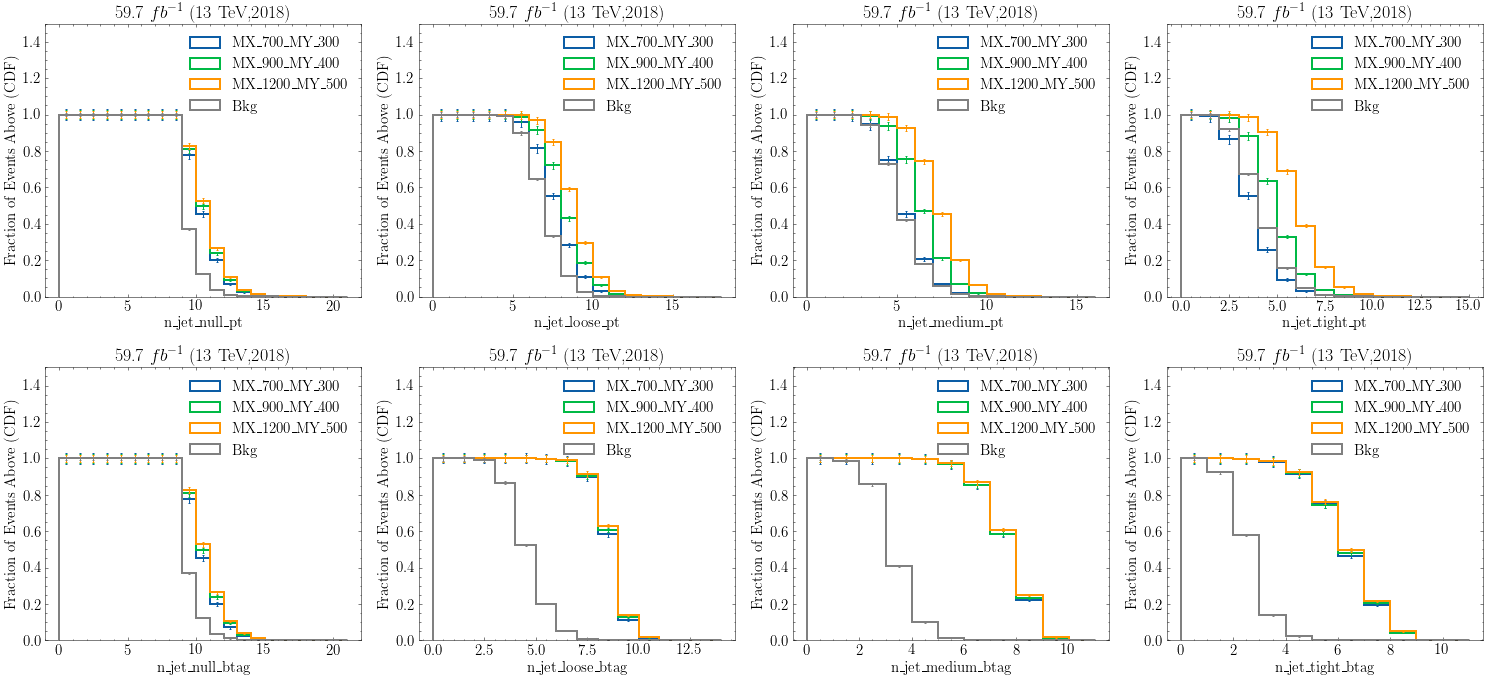

In [49]:
study.quick(
    signal_trees[[0,4,7]]+bkg_trees,
    varlist = [f'n_jet_{wp}_{var}' for var in ('pt','btag') for wp in wplabels ],
    density=True,
    s_label_stat=None,
    cumulative=-1,
    dim=(-1,4),
);

In [79]:
def mask_tree(tree):
    # mask = tree.n_jet_medium_btag > 3
    mask = tree.n_jet_medium_btag == 3
    return ak.sum(tree.scale[mask])/ak.sum(tree.scale)

(bkg_trees+signal_trees).apply(mask_tree)

[0.3090237432941566, 0.0035988108277264915, 0.0039861128970039884, 0.0035227806481916415, 0.005355687507276749, 0.0032894736842105274, 0.004311322895393694, 0.0035708354094004325, 0.004024269440316989]

In [80]:
medium_4btag_filter = EventFilter("medium_4btag",filter=lambda t : t.n_jet_medium_btag > 3)
medium_inv_3btag_filter = EventFilter("medium_inv_3btag",filter=lambda t : t.n_jet_medium_btag == 3)

In [81]:
all_trees_v1 = (bkg_trees + signal_trees[[0,4,7]]).apply(medium_4btag_filter.filter)
all_trees_v2 = (bkg_trees + signal_trees[[0,4,7]]).apply(medium_inv_3btag_filter.filter)


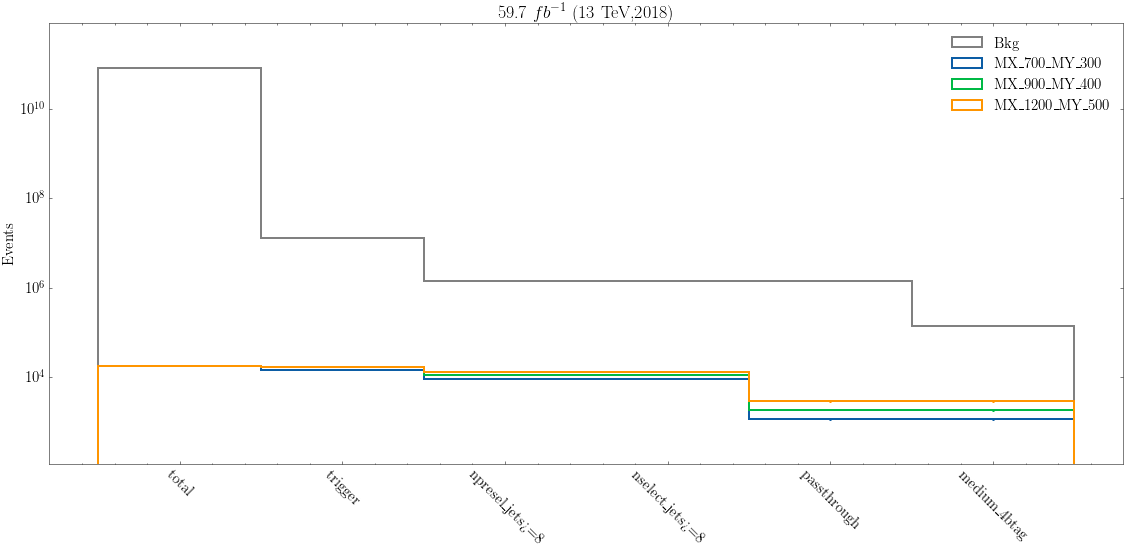

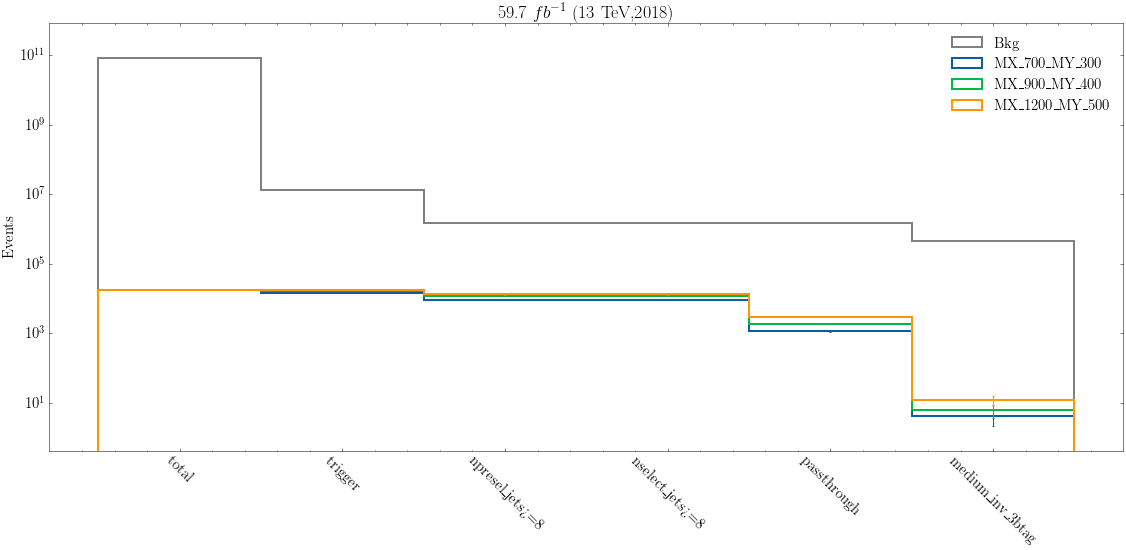

(<Figure size 1152x576 with 1 Axes>,
 <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, ylabel='Events'>)

In [82]:
study.cutflow(
    all_trees_v1
)

study.cutflow(
    all_trees_v2
)

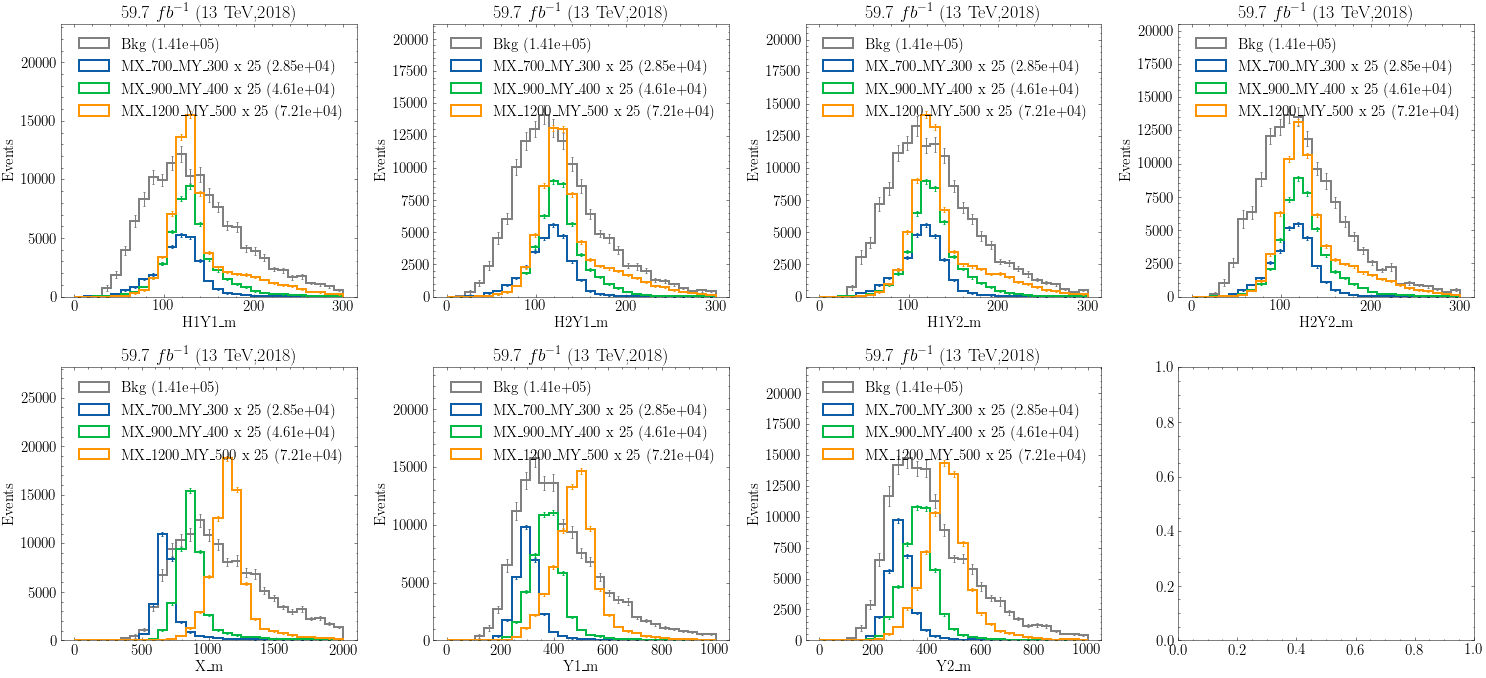

(<Figure size 1512x720 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H1Y1_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H2Y1_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H1Y2_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H2Y2_m', ylabel='Events'>],
        [<AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='X_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='Y1_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='Y2_m', ylabel='Events'>,
         <AxesSubplot:>]], dtype=object))

In [83]:
varinfo.X_m = dict(bins=np.linspace(0,2000,30))
varinfo.Y1_m = dict(bins=np.linspace(0,1000,30))
varinfo.Y2_m = dict(bins=np.linspace(0,1000,30))
varinfo.H1Y1_m = dict(bins=np.linspace(0,300,30))
varinfo.H1Y2_m = dict(bins=np.linspace(0,300,30))
varinfo.H2Y1_m = dict(bins=np.linspace(0,300,30))
varinfo.H2Y2_m = dict(bins=np.linspace(0,300,30))

study.quick(
    all_trees_v1,
    varlist=[f'{v}_m' for v in eightb.higgslist + ['X'] + eightb.ylist  ],
    s_xsec_scales=[None]+[25]*3,
    dim=(-1,4)
)

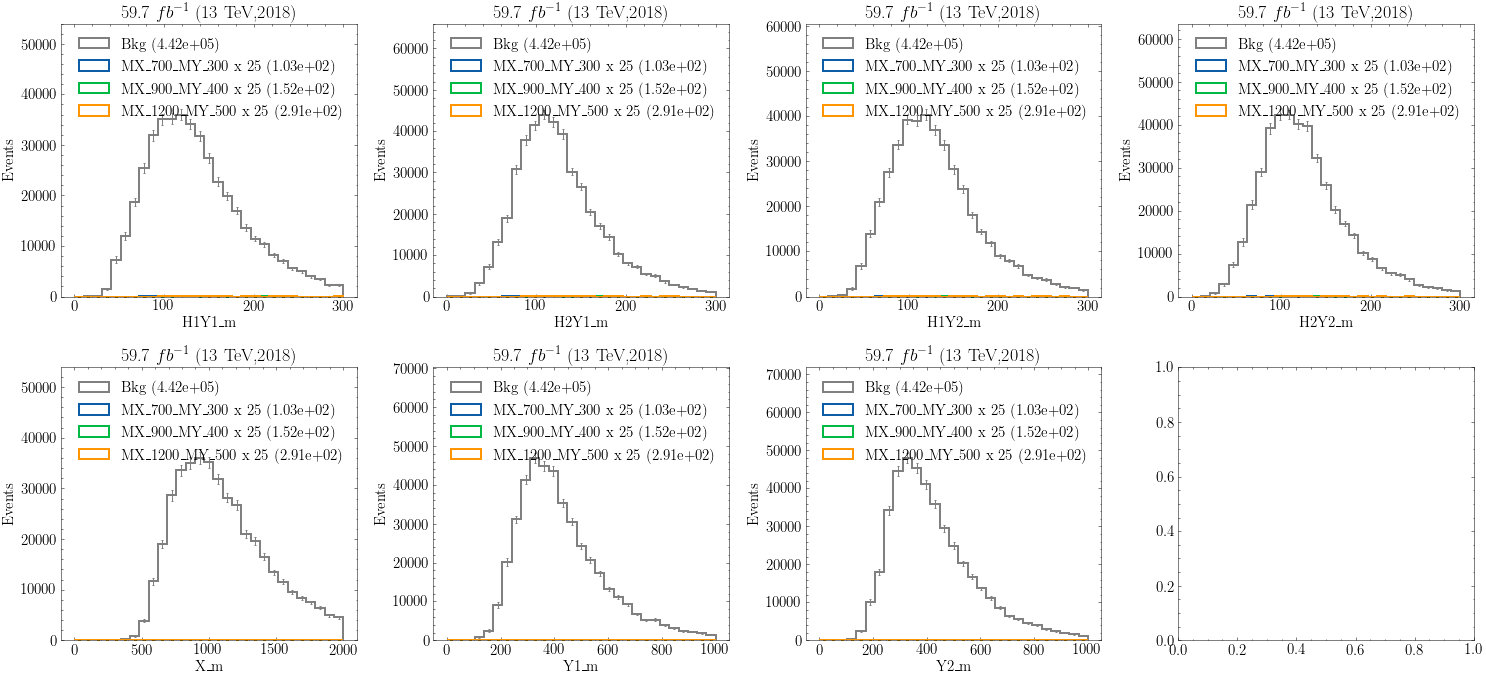

(<Figure size 1512x720 with 8 Axes>,
 array([[<AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H1Y1_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H2Y1_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H1Y2_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='H2Y2_m', ylabel='Events'>],
        [<AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='X_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='Y1_m', ylabel='Events'>,
         <AxesSubplot:title={'center':'59.7 $fb^{-1}$ (13 TeV,2018)'}, xlabel='Y2_m', ylabel='Events'>,
         <AxesSubplot:>]], dtype=object))

In [84]:
study.quick(
    all_trees_v2,
    varlist=[f'{v}_m' for v in eightb.higgslist + ['X'] + eightb.ylist  ],
    s_xsec_scales=[None]+[25]*3,
    dim=(-1,4)
)